In [1]:
print("hello world")
from usr_func import *

hello world


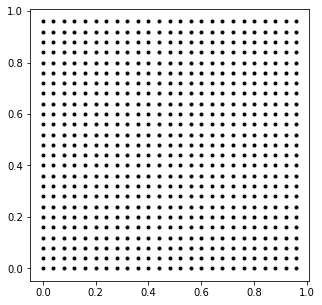

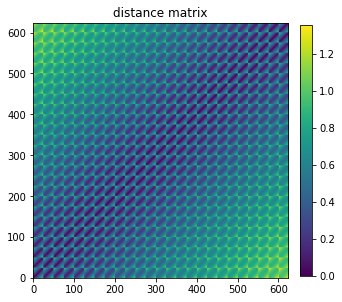

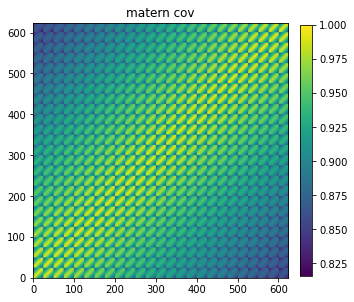

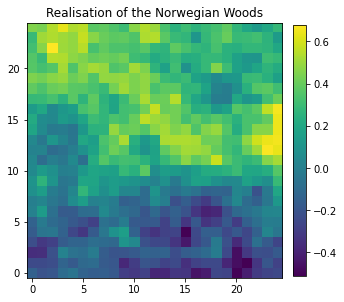

In [2]:
################################################################################################
# Section I : Set up grid
################################################################################################
# Discretise the grid
n1 = 25 # number of grid points along east direction
n2 = 25 # number of grid points along north direction
n = n1 * n2 # total number of grid points

dn1 = 1/n1
dn2 = 1/n2
sites1 = np.arange(0, 1, dn1).reshape(-1, 1)
sites2 = np.arange(0, 1, dn2).reshape(-1, 1)
ww1 = np.ones([n1, 1])
ww2 = np.ones([n2, 1])
sites1m = sites1 * ww1.T # sites1m is the matrix version of sites1
sites2m = ww2 * sites2.T

sites1v = sites1m.flatten().reshape(-1, 1) # sites1v is the vectorised version
sites2v = sites2m.flatten().reshape(-1, 1)

plt.figure(figsize=(5, 5))
plt.plot(sites1v, sites2v, 'k.')
plt.show()

################################################################################################
# Section I : Compute distance matrix
################################################################################################
# Compute the distance matrix
ddE = np.abs(sites1v * np.ones([1, n]) - np.ones([n, 1]) * sites1v.T)
dd2E = ddE * ddE
ddN = np.abs(sites2v * np.ones([1, n]) - np.ones([n, 1]) * sites2v.T)
dd2N = ddN * ddN
t = np.sqrt(dd2E + dd2N)
plotf(t, "distance matrix")

################################################################################################
# Section I : Compute covariance matrix
################################################################################################
# Compute the exponential covariance
eta = -3/20 # range coef in exponential kernel, 3/20 == .15
tau = 5 # iid noise for measuring, y = x + e(0, 5^2)

Sigma = Exp_cov(eta, t)  # matern covariance
plotf(Sigma, "matern cov")


################################################################################################
# Section I : Simulate the random field
################################################################################################
# Generate the realisation of the GRF
L = np.linalg.cholesky(Sigma)  # lower triangle matrix
x = np.dot(L, np.random.randn(n).reshape(-1, 1))
H = design_matrix(sites1v, sites2v) # different notation for the project
mu_prior = np.zeros([n, 1])
mu_real = mu_prior + x  # add covariance
plotf(np.copy(mu_real).reshape(n1, n2), "Realisation of the Norwegian Woods")

In [8]:
###############################################################################################
# Section II : Sampling with variance reduction
###############################################################################################
# design the sampling
M = n1
F = np.zeros([M, n])
# j = 20
mu_posterior = mu_prior
Sigma_posterior = Sigma
T = np.identity(M) * tau ** 2  # T matrix for the measurement error

No_steps = 10
vr = np.zeros([No_steps, n2])

for k in range(No_steps):
    j_next, vr_temp = MVR_sampling(mu_posterior, Sigma_posterior, tau, M, n1, n2, n)
    vr[k, :] = vr_temp.T
    print("Step no.", k, "\t j next is ", j_next, "\t total std error is ", np.sum(np.sqrt(vr_temp)))
    F = np.zeros([M, n])
    for i in range(M):
        tempM = np.zeros([n1, n2])
        tempM[i, j_next] = True
        F[i, :] = np.ravel(tempM)

    y_sampled = np.dot(F, mu_posterior) + tau * np.random.randn(M).reshape(-1, 1)
    mu_posterior, Sigma_posterior = GRF2D(Sigma_posterior, F, T, y_sampled, mu_posterior)
    plotf(np.diag(Sigma_posterior).reshape(n1, n2), "std_mvr_{:03d}".format(k))
plt.close("all")

Step no. 0 	 j next is  12 	 total std error is  18.71467772024084
Step no. 1 	 j next is  10 	 total std error is  15.795559389822701
Step no. 2 	 j next is  18 	 total std error is  14.112563539125162
Step no. 3 	 j next is  5 	 total std error is  12.972682833032101
Step no. 4 	 j next is  20 	 total std error is  12.134766693123415
Step no. 5 	 j next is  4 	 total std error is  11.49745009651934
Step no. 6 	 j next is  17 	 total std error is  10.983661077444934
Step no. 7 	 j next is  3 	 total std error is  10.568761782833086
Step no. 8 	 j next is  22 	 total std error is  10.220515882406962
Step no. 9 	 j next is  7 	 total std error is  9.913242597769676
Step no. 10 	 j next is  21 	 total std error is  9.654714199747398
Step no. 11 	 j next is  1 	 total std error is  9.427398744593619
Step no. 12 	 j next is  15 	 total std error is  9.219961462338034
Step no. 13 	 j next is  8 	 total std error is  9.03839894678954
Step no. 14 	 j next is  23 	 total std error is  8.877896

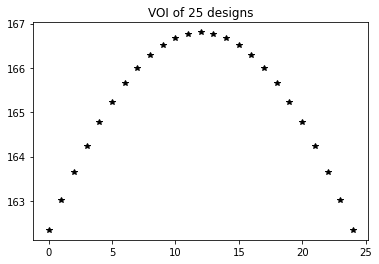

In [10]:
################################################################################################
# Section III : Sampling with sequential design based on VOI
################################################################################################
# static design: i.e. no adaptive selection, only one by one ish
M = n1
T = np.identity(M) * tau ** 2 # measurement error matrix
voi = np.zeros([M, 1])
for j in range(n2):
    F = np.zeros([M, n])
    for i in range(M):
        tempM = np.zeros([n1, n2])
        tempM[i, j] = True
        F[i, :] = np.ravel(tempM)

    pov = PoV(mu_prior, Sigma, T, F)
    pv = PV(mu_prior)
    voi[j]= VOI(pov, pv)

plt.figure()
plt.plot(voi, 'k*')
plt.title("VOI of 25 designs")
plt.show()
# plt.savefig("fig/voi.png")



In [ ]:
################################################################################################
# Section III : Sampling with sequential design based on VOI
################################################################################################
# sequential design based on maximum VOI until lower than Price

Price = .5
# VOI_sampling(mu_prior, Sigma_prior, tau, M, n, n1, n2)


T = np.identity(M) * tau ** 2  # T matrix for the measurement error

Max_steps = 200
# voi = np.zeros([No_steps, n2])
j_selected = []
TRIAL = 100

for kk in range(TRIAL):
    j_next = 0
    no_step = 0
    mu_posterior = mu_prior
    Sigma_posterior = Sigma
    
    while no_step <= Max_steps and j_next != -1:
        j_next, voi_temp = VOI_sampling(Price, mu_posterior, Sigma_posterior, tau, M, n, n1, n2)
        # voi[k, :] = voi_temp.T
        print("j next is ", j_next)
        if j_next == -1:
            print("VOI is smaller than the price, not worthwhile anymore")
            break
        j_selected.append(j_next)
        F = np.zeros([M, n])
        for i in range(M):
            tempM = np.zeros([n1, n2])
            tempM[i, j_next] = True
            F[i, :] = np.ravel(tempM)
    
        y_sampled = np.dot(F, mu_posterior) + tau * np.random.randn(M).reshape(-1, 1)
        mu_posterior, Sigma_posterior = GRF2D(Sigma_posterior, F, T, y_sampled, mu_posterior)
        no_step += 1
        # print(["posterior variance{:03d}".format(k)])
        # plotf(np.diag(Sigma_posterior).reshape(n1, n2), "std_voi_{:03d}".format(k))




